<a href="https://colab.research.google.com/github/FerbeiPatricia/PMP-2024/blob/main/Homework6_PMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pymc as pm
import numpy as np

# Datele observate pentru fiecare zi
n_obs = [100, 120, 150, 90, 200, 110, 130]  # numărul total de vizitatori zilnic
k_obs = [10, 15, 20, 5, 25, 12, 18]  # numărul de achiziții finalizate zilnic

# Definim modelul PyMC
with pm.Model() as model:
    # Prior pentru fiecare rata zilnică p_i, folosind Beta(α=2, β=2)
    p = pm.Beta('p', alpha=2, beta=2, shape=len(n_obs))

    # Modelăm achizițiile zilnice k ca variabile binomiale
    k = pm.Binomial('k', n=n_obs, p=p, observed=k_obs)

    # Calculăm rata medie globală
    p_mean = pm.Deterministic('p_mean', pm.math.mean(p))

    # Mostrăm distribuția a posteriori
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.115,0.031,0.060,0.172,0.0,0.0,4560.0,2677.0,1.0
p[1],0.138,0.031,0.080,0.193,0.0,0.0,4164.0,2848.0,1.0
p[2],0.143,0.028,0.095,0.198,0.0,0.0,5549.0,2998.0,1.0
p[3],0.075,0.027,0.026,0.125,0.0,0.0,4513.0,2997.0,1.0
p[4],0.132,0.024,0.087,0.176,0.0,0.0,5874.0,3021.0,1.0
p[5],0.123,0.031,0.068,0.184,0.0,0.0,5811.0,2856.0,1.0
p[6],0.149,0.031,0.096,0.212,0.0,0.0,5491.0,3228.0,1.0
p_mean,0.125,0.011,0.104,0.145,0.0,0.0,5106.0,3362.0,1.0


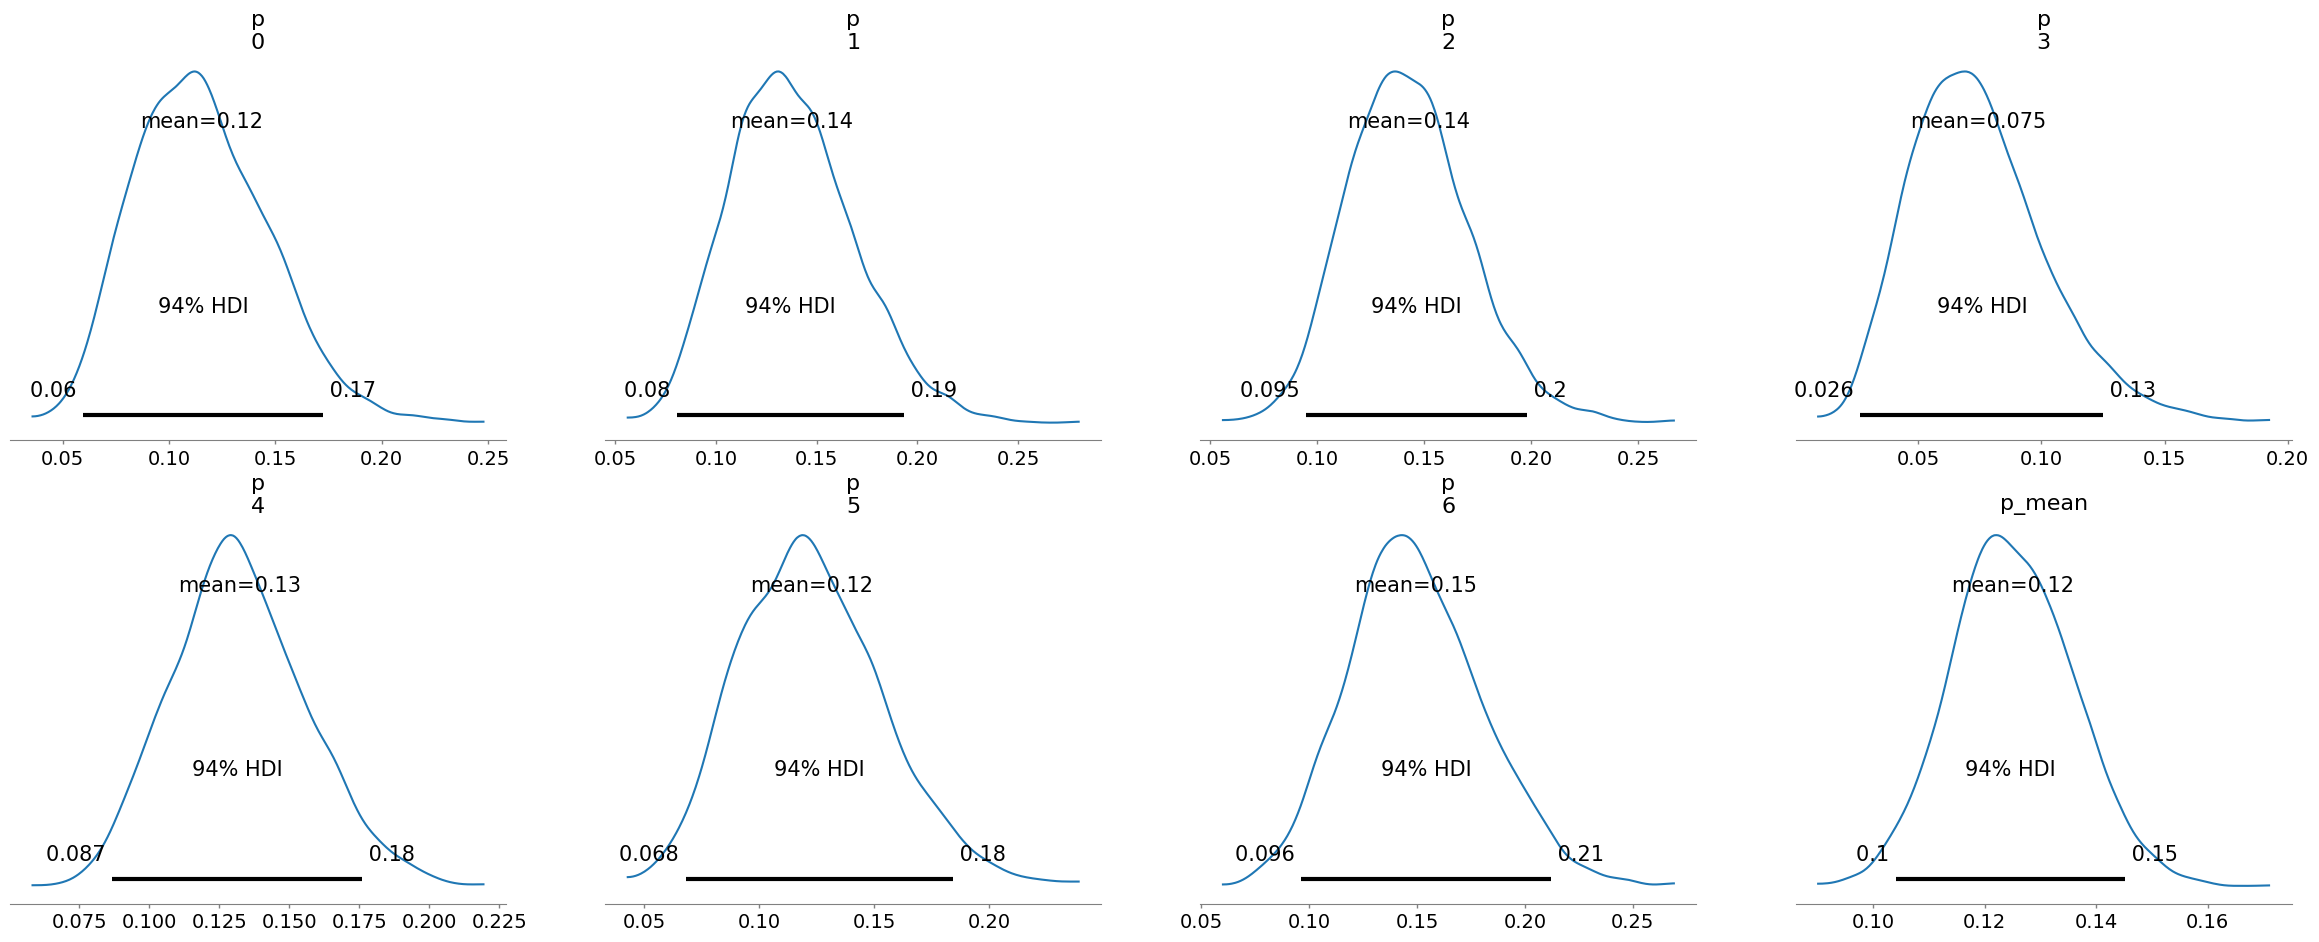

In [2]:
import arviz as az

# Vizualizare distribuții a posteriori
az.plot_posterior(trace, var_names=['p', 'p_mean'])
az.summary(trace, var_names=['p', 'p_mean'])


In [12]:
import pandas as pd
import pymc as pm
import numpy as np

# Încărcăm datele din fișierul 'trafic.csv'
data = pd.read_csv("trafic.csv")  # Asigurați-vă că fișierul există în mediu
minute_obs = data["minut"].values      # Coloana 'a' pentru minutele de la 4:00 la 24:00
trafic_obs = data["nr. masini"].values      # Coloana 'b' pentru numărul de mașini observate

# Definim punctele de schimbare în minute de la 4:00
# De exemplu, 4:00 = 0 minute, 7:00 = 180 minute, 8:00 = 240 minute, etc.
change_points = [180, 240, 720, 900]  # minutele corespunzătoare orelor 7:00, 8:00, 16:00 și 19:00

# Construim modelul în PyMC
with pm.Model() as traffic_model:
    # Priori pentru ratele de trafic λ în fiecare interval
    lambda_1 = pm.Exponential('lambda_1', 1.0)
    lambda_2 = pm.Exponential('lambda_2', 1.0)
    lambda_3 = pm.Exponential('lambda_3', 1.0)
    lambda_4 = pm.Exponential('lambda_4', 1.0)
    lambda_5 = pm.Exponential('lambda_5', 1.0)

    # Vectorul de rate λ care se aplică pentru fiecare interval
    lambda_ = pm.math.switch(
        minute_obs <= change_points[0], lambda_1,
        pm.math.switch(
            minute_obs <= change_points[1], lambda_2,
            pm.math.switch(
                minute_obs <= change_points[2], lambda_3,
                pm.math.switch(
                    minute_obs <= change_points[3], lambda_4,
                    lambda_5
                )
            )
        )
    )

    # Likelihood: numărul de mașini observate modelat ca o distribuție Poisson
    trafic = pm.Poisson('trafic', mu=lambda_, observed=trafic_obs)

    # Mostrăm distribuția a posteriori
    trace_traffic = pm.sample(2000, tune=1000, return_inferencedata=True)


Output()

Output()

Valori estimate pentru fiecare lambda:
Interval 1: λ_1 ~ 12.13 (95% HDI: [11.62, 12.66])
Interval 2: λ_2 ~ 17.00 (95% HDI: [15.99, 18.01])
Interval 3: λ_3 ~ 13.12 (95% HDI: [12.79, 13.44])
Interval 4: λ_4 ~ 14.54 (95% HDI: [13.99, 15.06])
Interval 5: λ_5 ~ 10.13 (95% HDI: [9.76, 10.49])


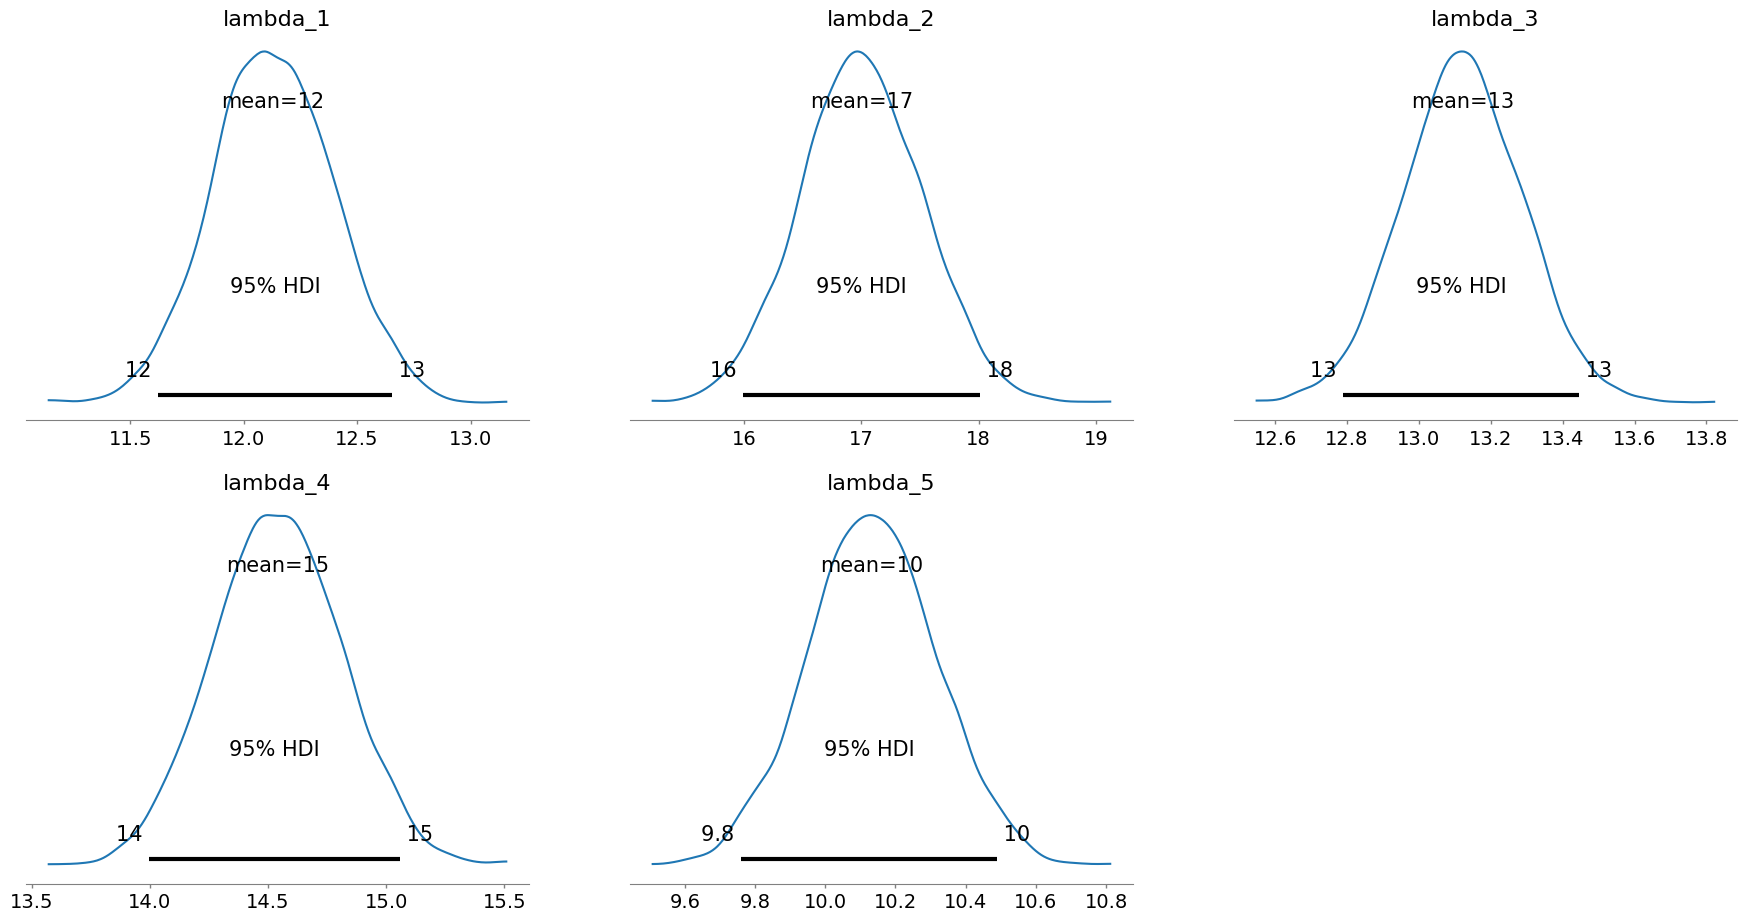

In [17]:
import arviz as az

# Plot posterior distributions pentru a vizualiza direct HDI
az.plot_posterior(trace_traffic, var_names=["lambda_1", "lambda_2", "lambda_3", "lambda_4", "lambda_5"], hdi_prob=0.95)

# Calculăm valorile medii și intervalele HDI pentru fiecare lambda
lambda_means = trace_traffic.posterior.mean(dim=["chain", "draw"])

# Extragem HDI pentru fiecare lambda
lambda_hdi = az.hdi(trace_traffic, hdi_prob=0.95)

print("Valori estimate pentru fiecare lambda:")
for i in range(1, 6):
    mean_val = lambda_means[f'lambda_{i}'].values  # Valoarea medie pentru fiecare lambda
    hdi_lower, hdi_upper = lambda_hdi[f'lambda_{i}'].values[0], lambda_hdi[f'lambda_{i}'].values[1]
    print(f"Interval {i}: λ_{i} ~ {mean_val:.2f} (95% HDI: [{hdi_lower:.2f}, {hdi_upper:.2f}])")
